In [44]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import argparse

import utils
import models
import datasets

In [45]:
 # load params
with open('./paths.json', 'r') as f:
    paths = json.load(f)

In [46]:
HIGH_RES = True
THRESHOLD = 0.5
DISABLE_OCEAN_MASK = False
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
TAXA = 13270
SET_MAX_CMAP_TO_1 = False

In [47]:

# load model
train_params = torch.load('./pretrained_models/model_an_full_input_enc_sin_cos_hard_cap_num_per_class_1000.pt', map_location='cpu')
model = models.get_model(train_params['params'])
model.load_state_dict(train_params['state_dict'], strict=True)
model = model.to(DEVICE)
model.eval()

ResidualFCNet(
  (class_emb): Linear(in_features=256, out_features=47375, bias=False)
  (feats): Sequential(
    (0): Linear(in_features=4, out_features=256, bias=True)
    (1): ReLU(inplace=True)
    (2): ResLayer(
      (nonlin1): ReLU(inplace=True)
      (nonlin2): ReLU(inplace=True)
      (dropout1): Dropout(p=0.5, inplace=False)
      (w1): Linear(in_features=256, out_features=256, bias=True)
      (w2): Linear(in_features=256, out_features=256, bias=True)
    )
    (3): ResLayer(
      (nonlin1): ReLU(inplace=True)
      (nonlin2): ReLU(inplace=True)
      (dropout1): Dropout(p=0.5, inplace=False)
      (w1): Linear(in_features=256, out_features=256, bias=True)
      (w2): Linear(in_features=256, out_features=256, bias=True)
    )
    (4): ResLayer(
      (nonlin1): ReLU(inplace=True)
      (nonlin2): ReLU(inplace=True)
      (dropout1): Dropout(p=0.5, inplace=False)
      (w1): Linear(in_features=256, out_features=256, bias=True)
      (w2): Linear(in_features=256, out_features=

In [48]:
if train_params['params']['input_enc'] in ['env', 'sin_cos_env']:
    raster = datasets.load_env()
else:
    raster = None
enc = utils.CoordEncoder(train_params['params']['input_enc'], raster=raster)

In [49]:
class_of_interest = train_params['params']['class_to_taxa'].index(TAXA)

In [50]:
 # load ocean mask
if HIGH_RES:
    mask = np.load('./data/masks/ocean_mask_hr.npy')
else:
    mask = np.load('./data/masks/ocean_mask.npy')
mask_inds = np.where(mask.reshape(-1) == 1)[0]

In [51]:
print(mask.shape)
locs = utils.coord_grid(mask.shape)
print(locs.shape)
locs

(2004, 4008)
(8032032, 2)


array([[-180.     ,   90.     ],
       [-179.91016,   90.     ],
       [-179.82031,   90.     ],
       ...,
       [ 179.82031,  -90.     ],
       [ 179.91016,  -90.     ],
       [ 180.     ,  -90.     ]], dtype=float32)

In [52]:
# generate input features

if not DISABLE_OCEAN_MASK:
    locs = locs[mask_inds, :]
locs = torch.from_numpy(locs)
locs_enc = enc.encode(locs).to(DEVICE)

In [53]:
locs_enc.shape

torch.Size([1959834, 4])

In [54]:
# make prediction
with torch.no_grad():
    preds = model(locs_enc, return_feats=False, class_of_interest=class_of_interest).cpu().numpy()

In [55]:
preds.shape

(1959834,)

In [56]:
copy_preds = preds.copy()

In [57]:
np.mean(copy_preds)

0.008496127

In [58]:
thresholds = [0.02,0.1,0.5]

vals = np.arange(0,1,1/(len(thresholds)+1)) + 1/(len(thresholds)+1)
vals

array([0.25, 0.5 , 0.75, 1.  ])

In [59]:
copy_preds[preds<thresholds[0]] = vals[0]

In [60]:
copy_preds[preds<thresholds[0]] = vals[0]
for i in range(len(thresholds)):
    copy_preds[preds>thresholds[i]] = vals[i+1]

In [61]:
np.unique(copy_preds)

array([0.25, 0.5 , 0.75, 1.  ], dtype=float32)

In [62]:
# mask data
if not DISABLE_OCEAN_MASK:
    op_im = np.ones((mask.shape[0] * mask.shape[1])) * np.nan  # set to NaN
    op_im[mask_inds] = copy_preds
else:
    op_im = copy_preds

In [63]:
# reshape and create masked array for visualization
op_im = op_im.reshape((mask.shape[0], mask.shape[1]))
op_im = np.ma.masked_invalid(op_im) 

# set color for masked values
cmap = plt.cm.Blues
cmap.set_bad(color='none')  
if SET_MAX_CMAP_TO_1:
    vmax = 1.0
else:
    vmax = np.max(op_im)

In [64]:
op_im.shape

(2004, 4008)

In [65]:
out = op_im[200:900,800:1300]

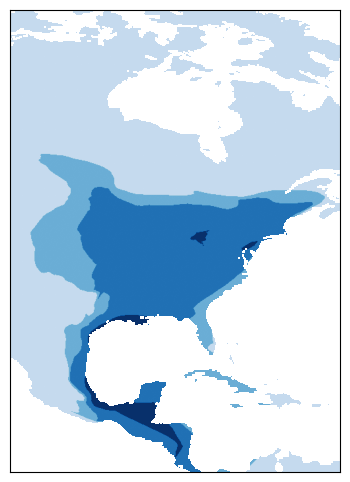

In [66]:
fig,ax = plt.subplots(1,figsize = (8, 6))
#plt.figure(figsize = (8, 6)) 
plt.imshow(X=out, vmin=0, vmax=vmax, cmap=cmap)
# Turn off tick labels
ax.set_xticks([])
ax.set_yticks([])
#ax.legend()
plt.show()